# Sharpe

Usage in C2Score:

- `posOrZero( %[Sharpe Ratio]% * 100 ) + ...`
- `+ ( %[Sharpe Ratio]% > 1 ? 1000 : 0)`
- `+ ( %[Sharpe Ratio]% > 1.3 ? 1000 : 0)`
- `+ ( %[Sharpe Ratio]% > 1 ? posOrZero( %Alpha% ) *100 : 0)`

Sharpe (and Sortino) is probably the most important statistic for us. We should look into data more deeper.

Statistics in historical_stats_modern are calculated WEEKLY on Collective2.

In [1]:
source("JupyterUtils.R")
source("C2ScoreHypothesisPresentation.R")

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD        NA's 
        7734      255241  -3037.5700     -0.7800      0.4900    -0.06716      1.4200    639.2100     15.8120        2489 


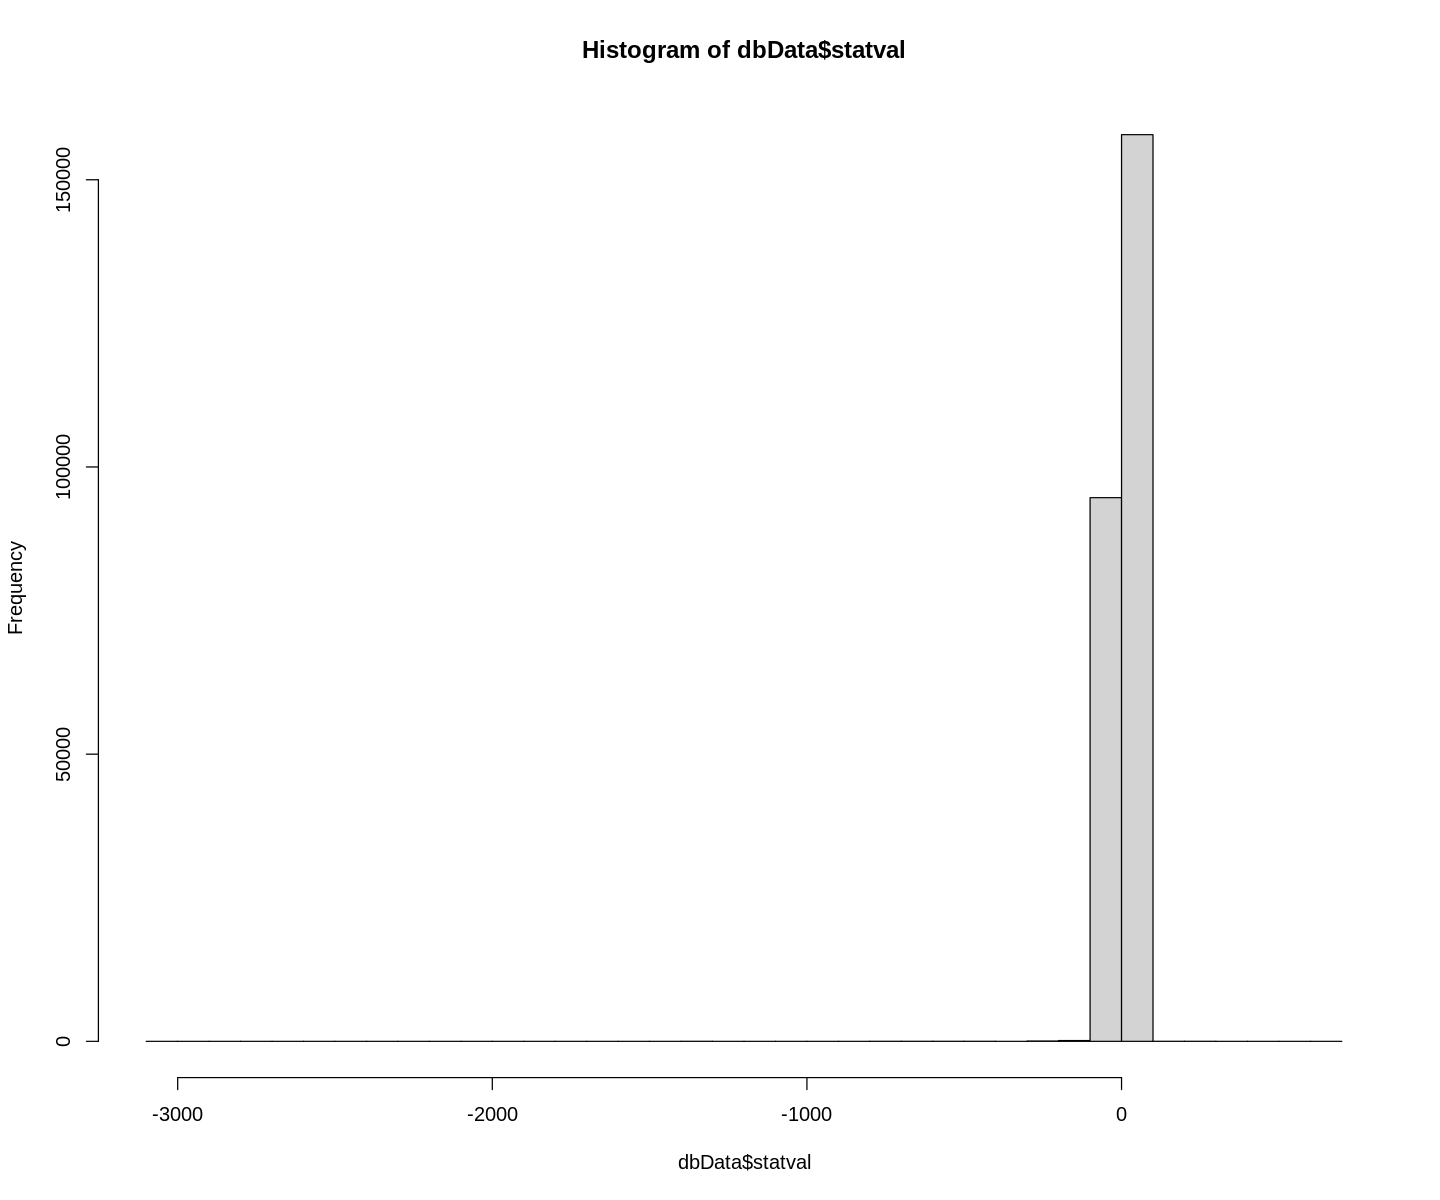

In [2]:
# What data we have.
dbData = getC2ScoreDbData("select systemid, YYYYMMDD, statval from historical_stats_modern where statname='jSharpe'")
overview(dbData)
hist(dbData$statval,breaks=50)

Apparently, data like -3000 and +639 can't be right. We need to find a reasonable values. 

Sharpe = 2 means 50% return and 25% SD.

Or, if we choose some still reasonable volatility in denominator, say 35% than the nominator (annual return) must be 70% for Sharpe = 2.

So real-world Sharpe would be 2. Daniil's suggestion is 4: _Strategies with a sharp ratio greater than 2 make up about 10% of the total sample of strategies older than 90 days. I think we need to expand the range to 4._

Sharpe is calculated for short-live strategies in the C2 database. [We do know](./C2Score_Doc_Math.ipynb), that we need 40-60 observations. So let's apply `Age > 90` condition. However: Statistics in `historical_stats_modern` are calculated WEEKLY on Collective2 so 52 observations represent 1 year. It affects our results. (Hypothesis tests are less reliable.)

We want just positive values.

     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1476       44871      0.0100      0.6300      1.0800      1.2525      1.7300      4.0000      0.8450 


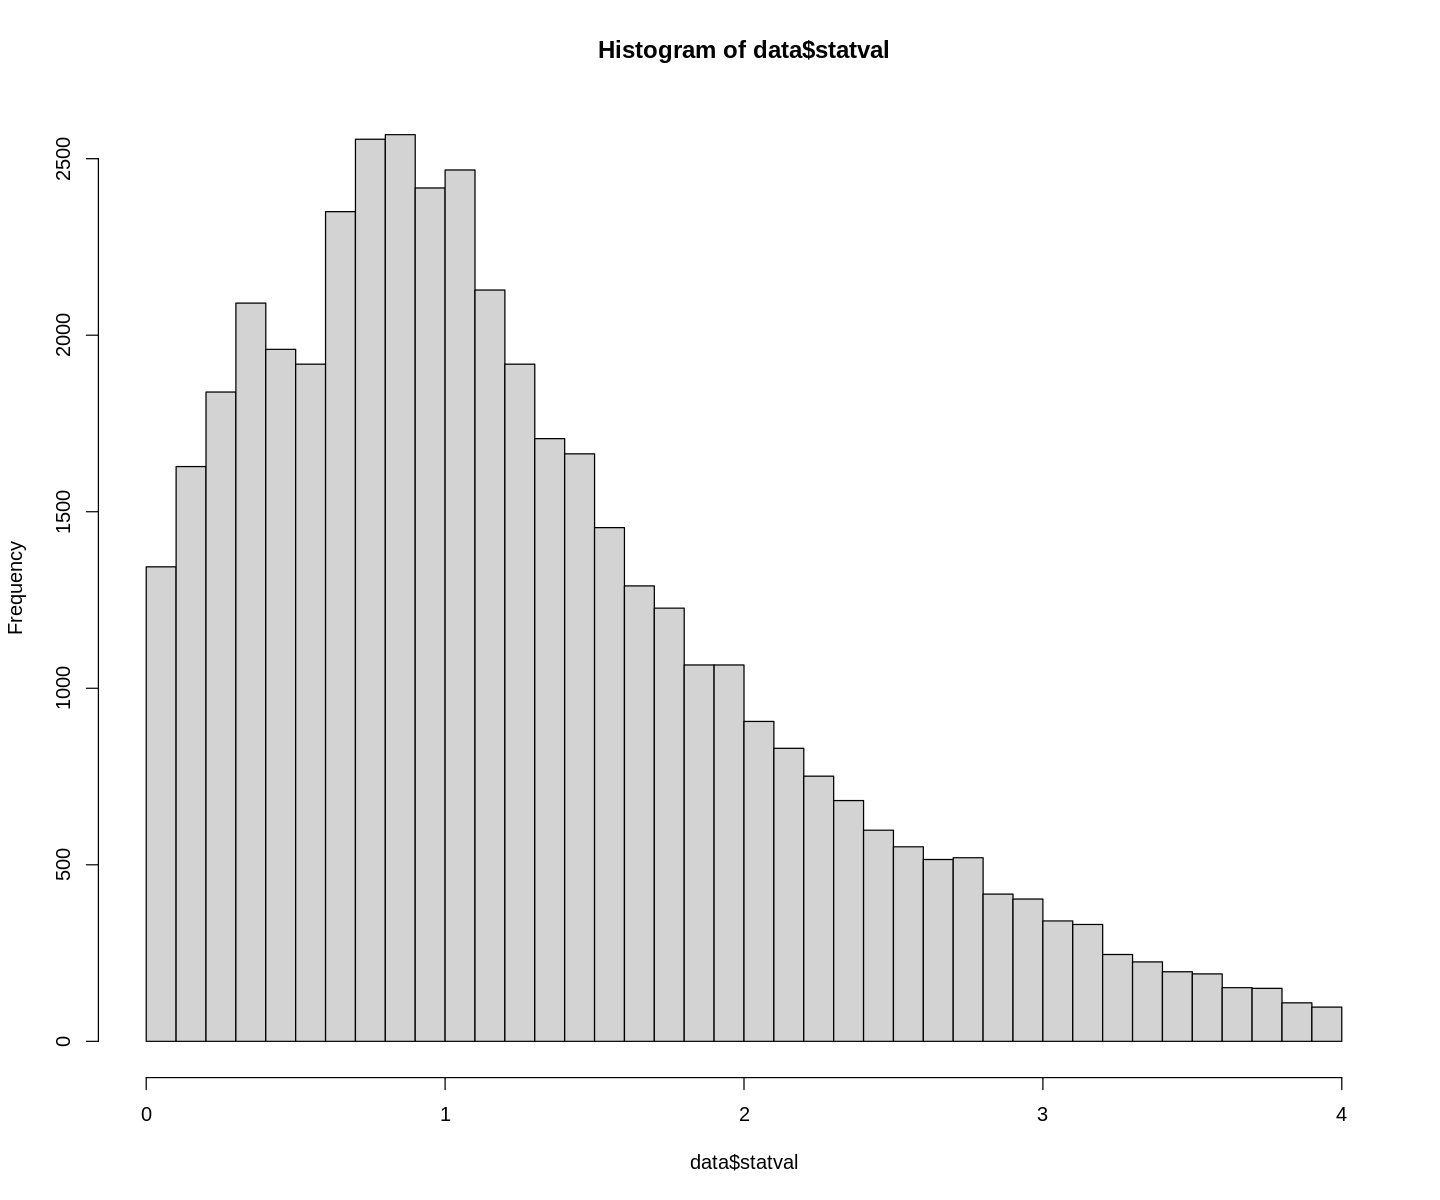

In [3]:
# Apply conditions and join with cleaned data
sql = "select statval, eq.*
 from ReturnsDataInIntervalsCleanedSkip090 eq
 join historical_stats_modern h on h.systemid=eq.systemid and h.YYYYMMDD = cast(date_format(DateStart,'%Y%m%d') AS UNSIGNED)
 where 
    statname='jSharpe' 
    and statval > 0 
    and statval <= 4 
    and Age > 90"

data = getC2ScoreDbData(sql)
overview(data)
hist(data$statval,breaks=50)



We have calculated and stored the whole population statistics of strategies daily returns after 7, 14, ..., 360 days. Day after day. Now, we selected a particular statistics data (a sample) from the whole population. Collective2 data are joined with a cleaned strategies set used for the population calculations. We want to know, if the average of returns of the sample is significantly higher than an average of returns of the whole population. A significance level is  0.05 .

The following table contains this hypothesis tests for defined stats intervals and all 7, 14, ..., 360 days time intervals.


Descriptive stats of all data selected in the experiment:
     Systems    Obsrvtns     Minimum     1st Qu.      Median        Mean     3rd Qu.     Maximum          SD 
        1476       44871      0.0100      0.6300      1.0800      1.2525      1.7300      4.0000      0.8450 



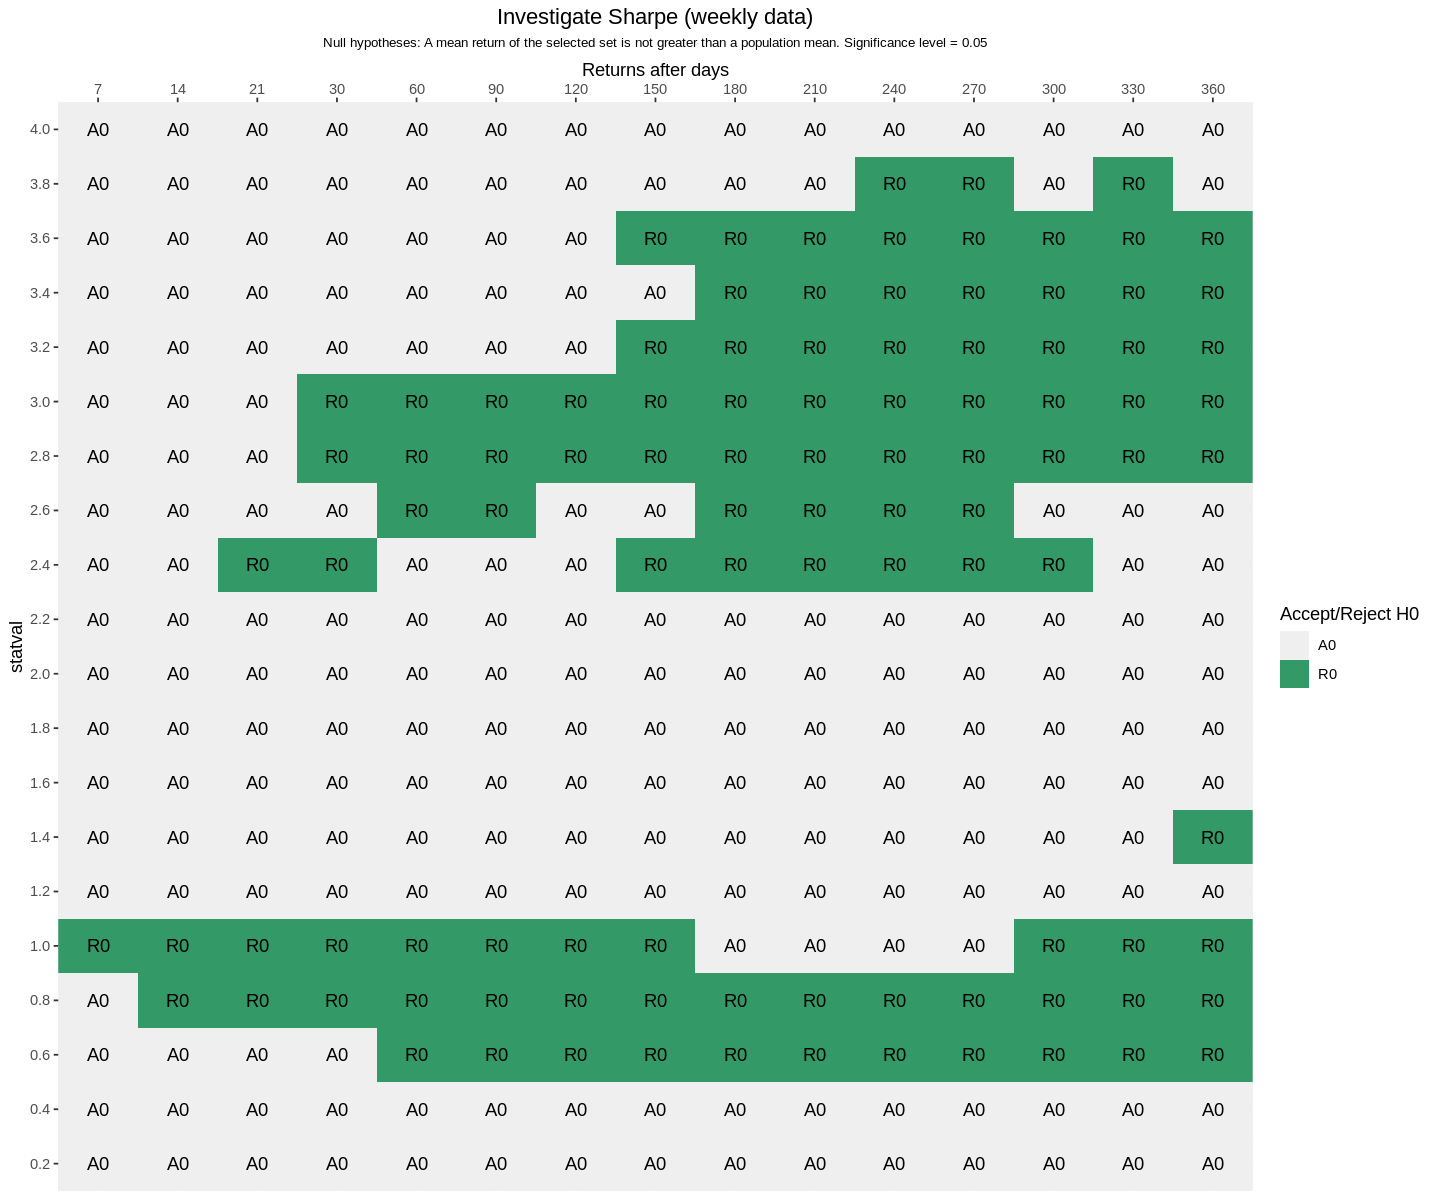

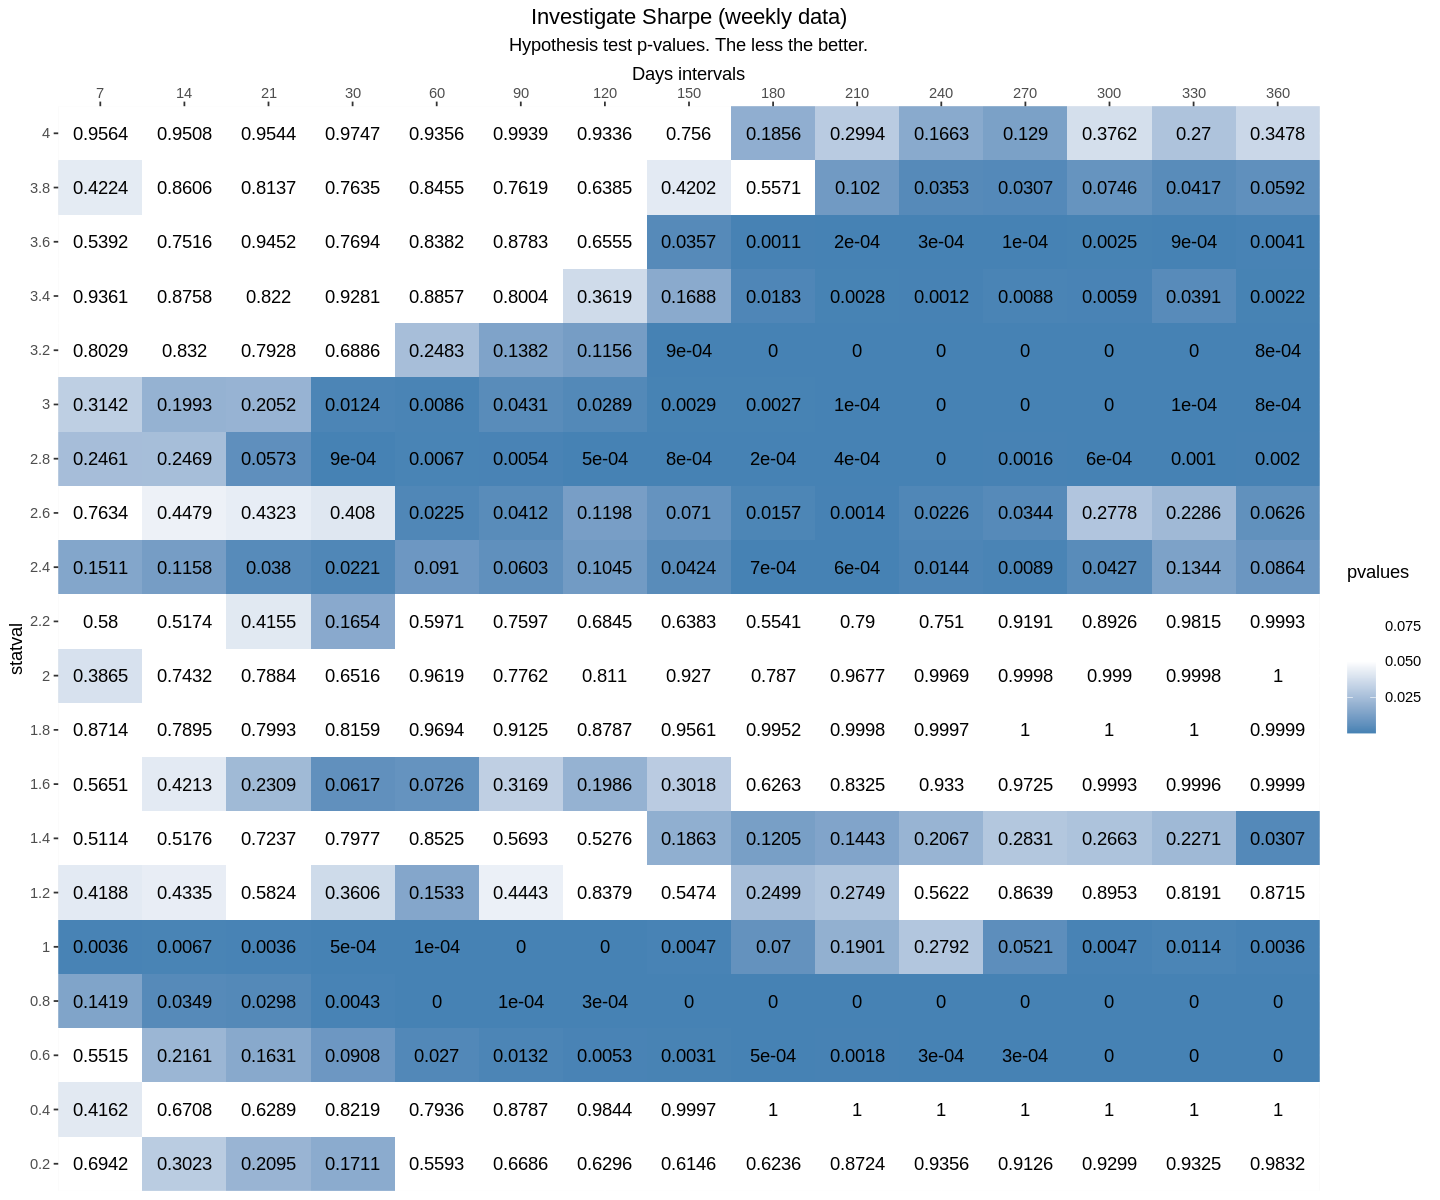

In [4]:
experiment = list(
  name = "Sharpe weekly, Age > 90",
  description = "Investigate Sharpe (weekly data)",
  sqlText = sql, # the latest sql above
  attributeName = "statval",
  attributeSteps = seq(from = 0, to = 4, by = 0.2))

result = makeExperiment(experiment)


Hypothesis test of sample standard deviation.

Alternative hypothesis: The sample standard deviation is less than the population SD.


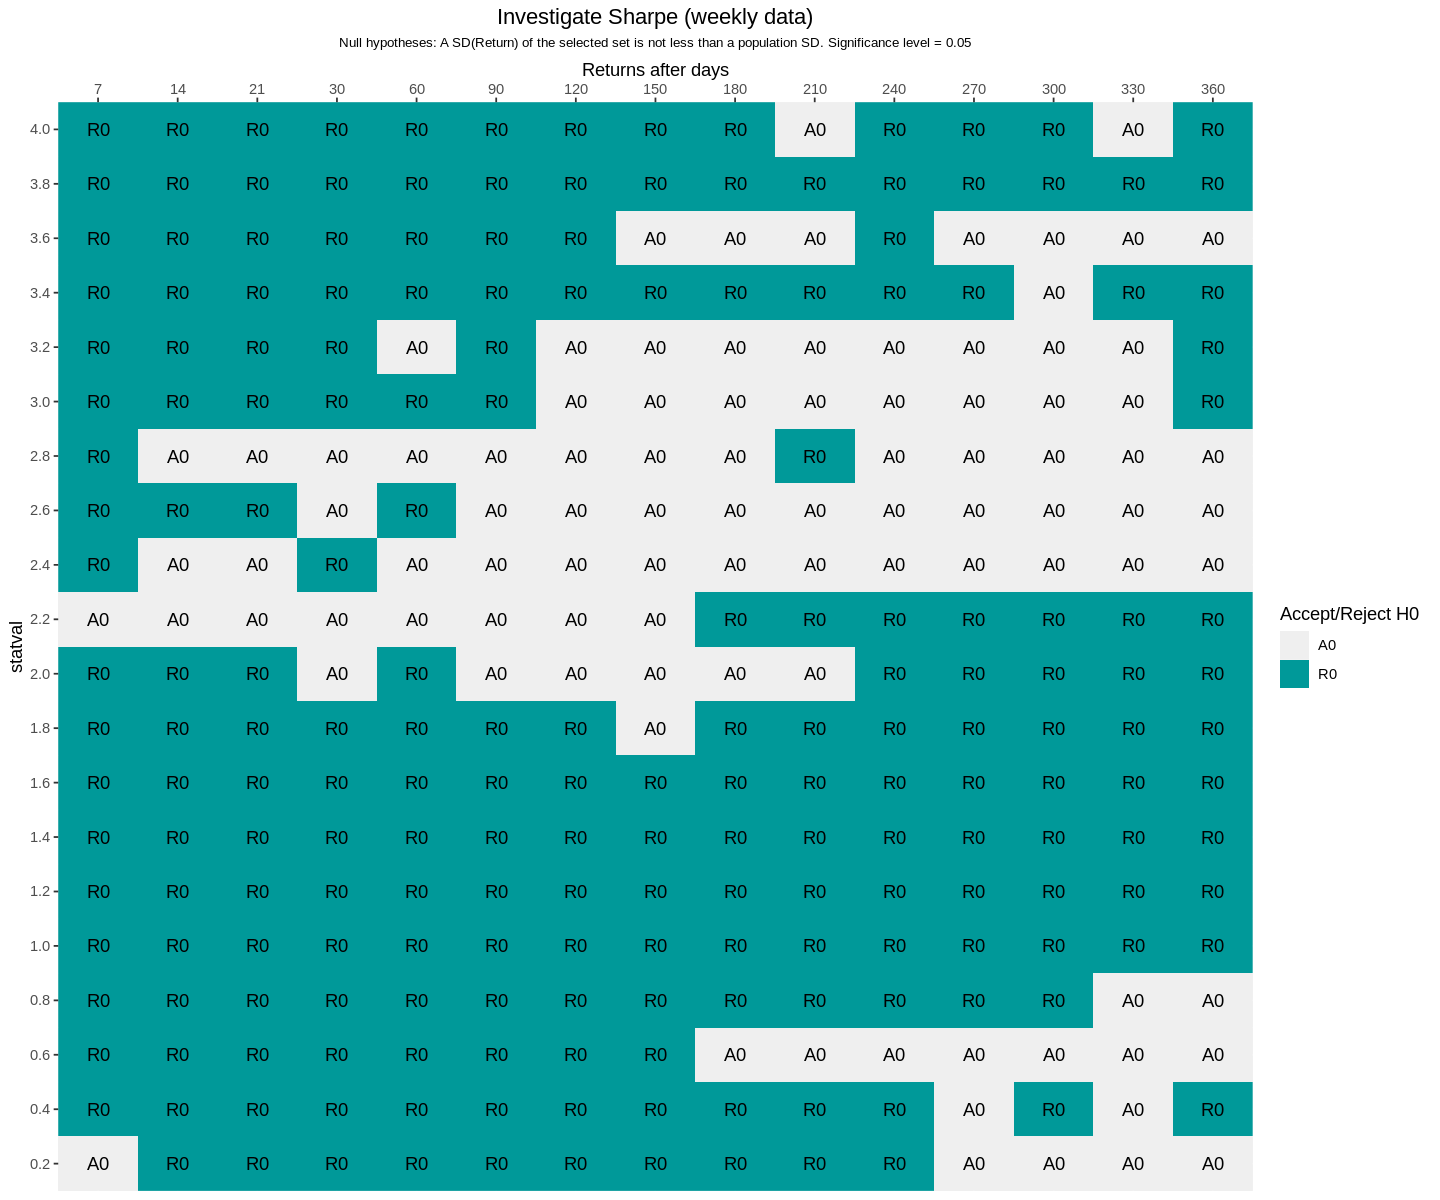

In [5]:
showSDLessHypothesisTest(experiment, result)

In [6]:
showObservationsCounts(experiment, result)


The following table contains numbers of observations in the used statistics intervals.
A number of observations in the sample is an important part of the hypothesis testing. Be careful if it is low (less than 30).
Collective2 data are calculated in 7-days intervals. It means we have less observations which decreases hypotesis testing reliability. Use daily data tests if available.
Numbers of observations shown in this table are NOT numbers of C2 strategies! Every strategy can have many observations in any statistics interval. That is what is shown here.


Selection,Obs007,Obs014,Obs021,Obs030,Obs060,Obs090,Obs120,Obs150,Obs180,Obs210,Obs240,Obs270,Obs300,Obs330,Obs360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.8 <= statval < 4,195,193,189,184,167,154,138,132,123,115,101,87,83,72,66
3.6 <= statval < 3.8,317,312,308,300,279,260,237,223,204,175,163,144,133,119,105
3.4 <= statval < 3.6,363,358,351,341,326,298,274,245,216,197,178,166,144,122,100
3.2 <= statval < 3.4,493,482,474,466,435,388,346,314,282,259,237,210,187,157,129
3 <= statval < 3.2,662,651,643,634,576,523,481,437,385,344,308,278,247,206,184
2.8 <= statval < 3,775,767,754,731,661,620,568,496,433,385,341,305,271,248,217
2.6 <= statval < 2.8,1078,1062,1037,1011,911,789,705,621,529,477,433,362,328,288,260
2.4 <= statval < 2.6,1063,1045,1023,994,874,796,723,643,578,521,475,428,393,363,331
2.2 <= statval < 2.4,1478,1444,1415,1378,1211,1086,1007,913,819,753,694,620,560,521,470



SampleMetricValue minus PopulationMetricValue

This table shows differences between metric values calculated for the whole population and the current sample metric values. (See the chapter 'Population statistics'.)
This is different from our hypothesis test. Our hypothesis test tests an (alternative) hypothesis 'Is a mean of the sample greater than a mean of the population?'
But our metric is 'Mean divided by SD'. So the standard deviation plays a role in it.
Our metric is greater when a numerator is greater and/or denominator is less. It is up to you what you prefer.



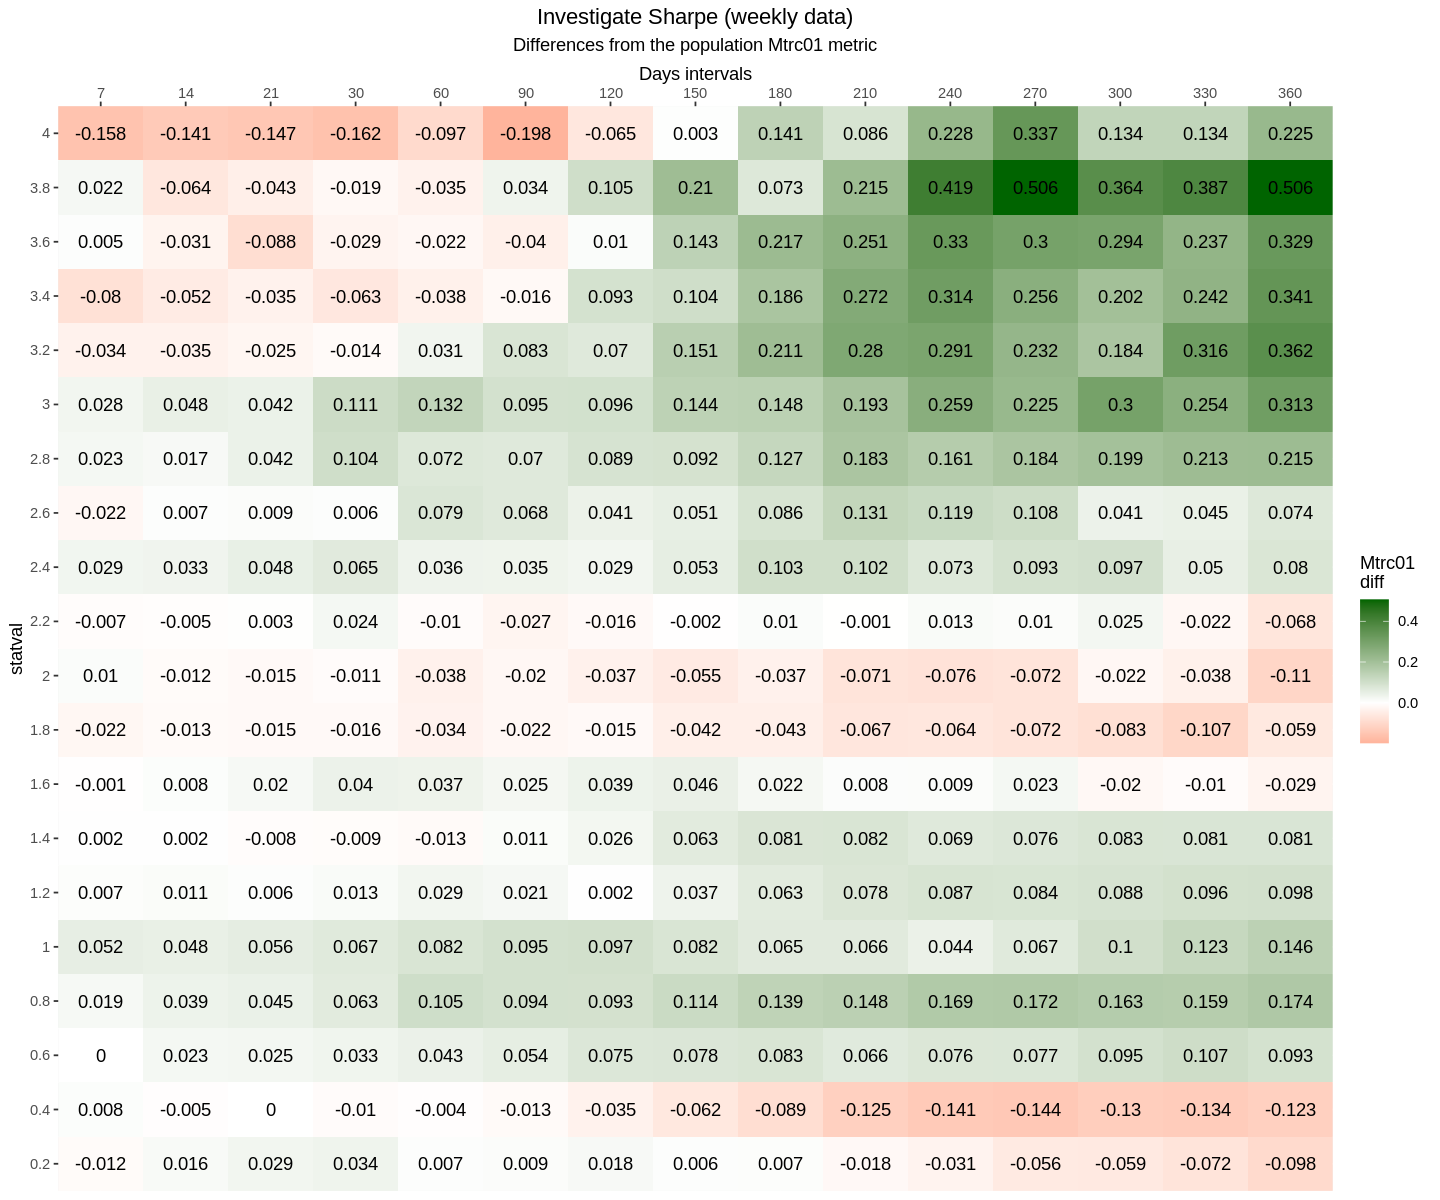

In [7]:
showMetricDifferences(experiment, result)

In [8]:
showSystemsCounts(experiment, result)



Numbers of strategies observed in defined intervals.

Selection,Sys007,Sys014,Sys021,Sys030,Sys060,Sys090,Sys120,Sys150,Sys180,Sys210,Sys240,Sys270,Sys300,Sys330,Sys360
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.8 <= statval < 4,103,102,101,99,88,80,72,66,61,56,51,46,43,36,31
3.6 <= statval < 3.8,132,129,129,124,114,106,90,86,80,69,65,58,52,47,44
3.4 <= statval < 3.6,165,161,158,150,143,128,116,105,92,84,77,71,65,58,48
3.2 <= statval < 3.4,198,191,187,182,170,148,131,120,106,99,88,79,72,63,53
3 <= statval < 3.2,241,235,231,228,201,183,164,151,131,118,108,96,90,76,64
2.8 <= statval < 3,268,262,257,246,212,198,183,163,145,131,117,104,93,82,69
2.6 <= statval < 2.8,330,325,318,306,274,233,213,196,169,156,147,126,106,92,83
2.4 <= statval < 2.6,348,342,333,321,285,257,222,192,167,151,140,119,103,100,87
2.2 <= statval < 2.4,406,396,390,379,329,279,252,221,196,174,154,137,122,111,104


### Discussion
 
........................
